# Image Classification with Logistic Regression (Minimal)



In [35]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla P100-PCIE-16GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [0]:
# Imports
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [0]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

## Dataset & Data loaders

In [0]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

Label: 4


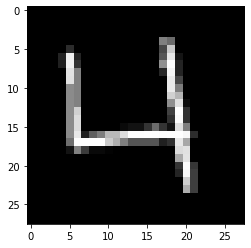

In [39]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

## Model

In [0]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256,128)
        self.linear4 = nn.Linear(128, 32)
        self.linear5 = nn.Linear(32, num_classes)
        
    def forward(self, xb):
        x = xb.reshape(-1,784)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        out = self.linear5(x)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

## Training

In [0]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, learning_rate, model, train_loader, val_loader):
    history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [43]:
evaluate(model, val_loader)

{'val_acc': 0.09433593600988388, 'val_loss': 2.3177099227905273}

In [44]:
history = fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1855, val_acc: 0.9459
Epoch [1], val_loss: 0.1270, val_acc: 0.9608
Epoch [2], val_loss: 0.1054, val_acc: 0.9663
Epoch [3], val_loss: 0.0938, val_acc: 0.9726
Epoch [4], val_loss: 0.0861, val_acc: 0.9766
Epoch [5], val_loss: 0.0969, val_acc: 0.9721
Epoch [6], val_loss: 0.0898, val_acc: 0.9741
Epoch [7], val_loss: 0.1016, val_acc: 0.9746
Epoch [8], val_loss: 0.0885, val_acc: 0.9766
Epoch [9], val_loss: 0.0974, val_acc: 0.9764


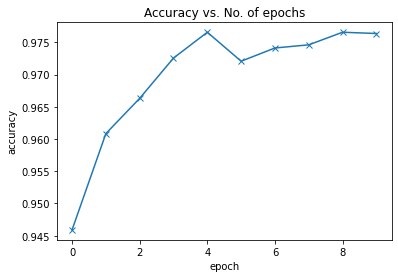

In [49]:
accuracies = [r['val_acc'] for r in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [50]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_acc': 0.975781261920929, 'val_loss': 0.09508315473794937}

## Prediction

In [0]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


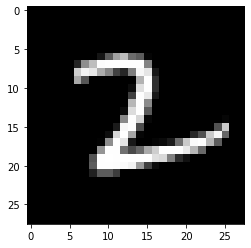

In [52]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))